In [1]:
import os

import models
from models import manager
from models import sequence2vector
from dataset.load_dataset import load_click

from tqdm import tqdm
import pandas as pd
import numpy as np
import tensorflow as tf


import importlib
importlib.reload(models.manager)

user_manager = manager.UserManager()
sku_manager = manager.SkuManager()

E:\project\python\20Spring\dataset\load_dataset.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import read_csv, datetime, to_datetime
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.preprocessing.label module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from s

In [2]:
def get_order_item(x):
    for sku_encoding in list(x):
        if 'True' in sku_encoding:
            return sku_encoding.split('__')[0]
        
    return 'NONE'

def parse_sku(x):
    if x == 'NONE':
        return 'NONE'
    else:
        return x.split('__')[0]
    
    
def negative_sampling(l):
    '''
    negative sampling, input number of classes, output function to do negative sampling
    
    input:
    ---------
    l: int
        number of classes
    
    output:
    ---------
    sampling: function of sample
    '''
    def sampling(rowData):
        rowData = np.array(rowData)
        negative_sample = np.random.choice(l)
        while negative_sample in rowData:
            negative_sample = np.random.choice(l)
        return negative_sample
    return sampling


In [6]:
df_sku_5_gram = pd.read_csv('./data/sku_5_gram.csv', header=None)
df_sku_5_gram.head()

,0,1,2,3,4
0,NONE,NONE,d6da3b2341__False__,93f9bac4b8__False__,NONE
1,NONE,d6da3b2341__False__,93f9bac4b8__False__,NONE,NONE
2,NONE,NONE,ed7a6a7cd7__False__,NONE,NONE
3,NONE,NONE,b24270b512__False__,NONE,NONE
4,NONE,NONE,adfedb6893__False__,c4ea4afceb__False__,adfedb6893__False__


In [18]:
df = pd.DataFrame()

df['order_item'] = df_sku_5_gram.apply(get_order_item, axis = 1)
df['center'] = df_sku_5_gram[2].apply(parse_sku)
df['context_1'] = df_sku_5_gram[0].apply(parse_sku)
df['context_2'] = df_sku_5_gram[1].apply(parse_sku)
df['context_3'] = df_sku_5_gram[3].apply(parse_sku)
df['context_4'] = df_sku_5_gram[4].apply(parse_sku)

df.head()

,order_item,center,context_1,context_2,context_3,context_4
0,NONE,d6da3b2341,NONE,NONE,93f9bac4b8,NONE
1,NONE,93f9bac4b8,NONE,d6da3b2341,NONE,NONE
2,NONE,ed7a6a7cd7,NONE,NONE,NONE,NONE
3,NONE,b24270b512,NONE,NONE,NONE,NONE
4,NONE,adfedb6893,NONE,NONE,c4ea4afceb,adfedb6893


In [19]:
df.head(55)

,order_item,center,context_1,context_2,context_3,context_4
0,NONE,d6da3b2341,NONE,NONE,93f9bac4b8,NONE
1,NONE,93f9bac4b8,NONE,d6da3b2341,NONE,NONE
2,NONE,ed7a6a7cd7,NONE,NONE,NONE,NONE
3,NONE,b24270b512,NONE,NONE,NONE,NONE
4,NONE,adfedb6893,NONE,NONE,c4ea4afceb,adfedb6893
5,NONE,c4ea4afceb,NONE,adfedb6893,adfedb6893,NONE
6,NONE,adfedb6893,adfedb6893,c4ea4afceb,NONE,NONE
7,NONE,4e5eaa6789,NONE,NONE,67d185f070,NONE
8,NONE,67d185f070,NONE,4e5eaa6789,NONE,NONE
9,NONE,bf0a360b17,NONE,NONE,NONE,NONE


In [56]:
sku_manager = manager.SkuManager()

In [52]:
for column_name in df.columns:
    df[column_name] = df[column_name].apply(sku_manager.get_label_by_ID)
    
df.head(30)

,order_item,center,context_1,context_2,context_3,context_4
0,32194,27053,32194,32194,18710,32194
1,32194,18710,32194,27053,32194,32194
2,32194,29832,32194,32194,32194,32194
3,32194,22523,32194,32194,32194,32194
4,32194,21935,32194,32194,24836,21935
5,32194,24836,32194,21935,21935,32194
6,32194,21935,21935,24836,32194,32194
7,32194,10040,32194,32194,13160,32194
8,32194,13160,32194,10040,32194,32194
9,32194,24097,32194,32194,32194,32194


In [57]:
attrs = ['center', 'context_1', 'context_2', 'context_3', 'context_4']
df['neg_1'] = df[attrs].apply(negative_sampling(num_sku), axis = 1)
df['neg_2'] = df[attrs].apply(negative_sampling(sku_manager.get_num_sku()), axis = 1)
df['neg_3'] = df[attrs].apply(negative_sampling(sku_manager.get_num_sku()), axis = 1)
df['neg_4'] = df[attrs].apply(negative_sampling(sku_manager.get_num_sku()), axis = 1)

df.head(30)

,order_item,center,context_1,context_2,context_3,context_4,neg_1,neg_2,neg_3,neg_4
0,32194,27053,32194,32194,18710,32194,5480,29768,9324,31062
1,32194,18710,32194,27053,32194,32194,10150,12158,18840,14523
2,32194,29832,32194,32194,32194,32194,22519,9073,18854,20995
3,32194,22523,32194,32194,32194,32194,22120,1315,1858,3476
4,32194,21935,32194,32194,24836,21935,20832,28681,6794,12871
5,32194,24836,32194,21935,21935,32194,7351,25457,18994,30773
6,32194,21935,21935,24836,32194,32194,15992,23564,12318,6985
7,32194,10040,32194,32194,13160,32194,12718,4016,7429,15534
8,32194,13160,32194,10040,32194,32194,5560,10649,14098,11323
9,32194,24097,32194,32194,32194,32194,7163,26450,18897,16446


In [58]:
df.to_csv('./data/sku_5_gram_for_word2vec.csv')

In [3]:
df = pd.read_csv('./data/sku_5_gram_for_word2vec.csv', index_col = 0)

C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [7]:
x_center = np.array(df['center']).reshape(-1,1)
x_context = np.array(df[['context_1', 'context_2', 'context_3', 'context_4']])
x_neg = np.array(df[['neg_1', 'neg_2', 'neg_3', 'neg_4']])
x_order = np.array(df['order_item']).reshape(-1,1)
y = np.ones((len(x_center), 1))

In [14]:
sku2vec = sequence2vector.Sequence2VectorWithBuyer(sku_manager.get_num_sku()+1, 100,
                                                  penalty = 1e-6)

sku2vec.compile(optimizer='adam', loss = sequence2vector.negative_log_likelihood)

In [15]:
sku2vec.fit([x_center, x_context, x_neg, x_order], y=y,
           validation_split = 0.3, shuffle = True, batch_size = 1024,
           epochs=2)

Tensor("sequence2_vector_with_buyer_1/binomial_probability_1/Log:0", shape=(None, 9, None, 1), dtype=float32)
(None, 9, None, 1)
Train on 8012618 samples, validate on 3433980 samples
Epoch 1/2
Tensor("sequence2_vector_with_buyer_1/binomial_probability_1/Log:0", shape=(None, 9, None, 1), dtype=float32)
(None, 9, None, 1)


C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\82091\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Tensor("sequence2_vector_with_buyer_1/binomial_probability_1/Log:0", shape=(None, 9, None, 1), dtype=float32)
(None, 9, None, 1)
8009728/8012618 [============================>.] - ETA: 0s - loss: 0.3121Tensor("sequence2_vector_with_buyer_1/binomial_probability_1/Log:0", shape=(None, 9, None, 1), dtype=float32)
(None, 9, None, 1)
8012618/8012618 [==============================] - 219s 27us/sample - loss: 0.3120 - val_loss: 0.2983
Epoch 2/2
8012618/8012618 [==============================] - 216s 27us/sample - loss: 0.2955 - val_loss: 0.2969


In [16]:
sku2vec.save_weights('./models/5_gram_sku2vec_v2.h5')

In [22]:
sku2vec.to_vector([23880])

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[-0.40395737,  0.02379858, -0.09209008, -0.3729932 , -0.34405106,
         0.0444451 ,  0.38539854,  0.32071906,  0.34079435,  0.34914166,
         0.36159694, -0.04512838, -0.3982994 , -0.19801654, -0.38455737,
        -0.37936136, -0.23961055, -0.10706841, -0.2675347 ,  0.08941859,
        -0.14784788,  0.38919735,  0.42934805,  0.02392732,  0.26077977,
        -0.05020798, -0.08417261, -0.34049514, -0.06865705, -0.12417133,
         0.05745079,  0.09059039,  0.09340407, -0.00587474, -0.02489506,
        -0.05564968, -0.3902467 , -0.05612467,  0.00761773, -0.11796059,
        -0.08703298, -0.10444761, -0.36941776,  0.3606079 , -0.00742285,
        -0.00693664,  0.04205266,  0.37505683,  0.01593127, -0.09759294,
        -0.03794239,  0.02292478, -0.04556408, -0.04107983,  0.11445733,
        -0.3906563 ,  0.01625134,  0.20528919, -0.02009915, -0.11137802,
         0.0842455 ,  0.3183738 ,  0.01215153,  0.01812715, -0.36733383,
 

In [29]:
sku = np.arange(sku_manager.get_num_sku()+1)
sku_vectors = model(sku)

In [32]:
from sklearn.manifold import TSNE
sku_vectors = np.array(sku_vectors)

tsne = TSNE(n_components=2)
sku_tsne = tsne.fit_transform(sku_vectors)


In [36]:
pd.DataFrame(sku_tsne).to_csv('./output/5_gram_sku_vec_tsne.csv', index = None)
pd.DataFrame(sku_vectors).to_csv('./output/5_gram_sku_vec.csv', index = None)

In [3]:
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import joblib
user_encoder_v2 = joblib.load('./models/user_encoder.pkl')

df_user_request = pd.read_csv('./models/user_map.csv', index_col = 0)

user_encoder_v2.fit(df_user_request['attrs_combined'])

df_train = pd.DataFrame()
df_user_request['user_label'] = user_encoder_v2.transform(df_user_request['attrs_combined'])

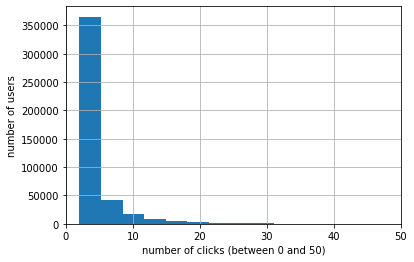

In [25]:
c = df_user_request['request_list'].apply(lambda x: len(set(x.split('__'))))

c.hist(bins=80)
plt.xlim(0, 50)
plt.xlabel('number of clicks (between 0 and 50)')
plt.ylabel('number of users')
plt.savefig('histogram_of_numClicks.png')

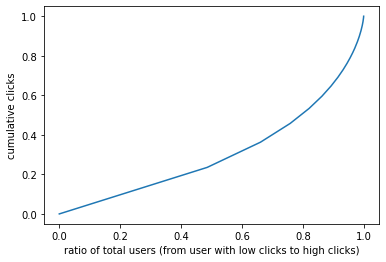

In [17]:
import matplotlib.pyplot as plt
xx = np.linspace(0, 1, len(x))
plt.plot(xx, x)
plt.xlabel('ratio of total users (from user with low clicks to high clicks)')
plt.ylabel('cumulative clicks')
plt.savefig('./figure/cumulative_clicks.png')

In [20]:
from sklearn.externals import joblib
with open('./recommendation_system/user_encoder.pkl', 'wb') as f:
    joblib.dump(user_encoder_v2, f)

In [7]:
X = []
y = []
sampling_func = negative_sampling(sku_manager.get_num_sku())
for _ in tqdm(range(len(df_user_request))):
    requests_list = set(df_user_request.iloc[_, 1].split('__')[:-1])
    user = df_user_request.iloc[_, -1]
    for request in requests_list:
        X.append([user, request])
        y.append(1)
        
        neg_sample = sampling_func(requests_list)
        X.append([user, neg_sample])
        y.append(0)
    
    

100%|███████████████████████████████████████████████████████████████████████| 446791/446791 [00:29<00:00, 15145.13it/s]


In [8]:
from sklearn.model_selection import train_test_split

X = np.array(X, dtype=int)
y = np.array(y).reshape(-1,1)

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=112)

x_user_train = x_train[:, 0].reshape(-1,1)
x_sku_train = x_train[:, 1].reshape(-1,1)

x_user_test = x_test[:, 0].reshape(-1,1)
x_sku_test = x_test[:, 1].reshape(-1,1)

In [25]:
np.save('recommendation_Y',y)

In [9]:
def build_seq2vec(num, embedding_dim, name, path=False, trainable=True):
    input_ = Input(shape=(1,))
    output = Embedding(num, embedding_dim, trainable=trainable)(input_)
    model = Model(inputs=input_, outputs=output, name=name)
    if path:
        model.load_weights(path)
    return model

In [69]:
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import Embedding, Input, Lambda, Concatenate, Dense, Flatten, Reshape
from tensorflow.keras import backend as K

num_user = len(user_encoder_v2.classes_)
num_sku = sku_manager.get_num_sku() + 1
path = './models/5_gram_sku2vec_v2.h5'

sku2vec = build_seq2vec(num_sku, 100, path=path, name='sku2vec',trainable=False)
sku2vec.load_weights('./models/5_gram_sku2vec_v2.h5')

user2vec_1 = build_seq2vec(num_user, 100, name='user2vec_1')
user2vec_2 = build_seq2vec(num_user, 100, name='user2vec_2')
user2vec_3 = build_seq2vec(num_user, 100, name='user2vec_3')

concat_layer = Concatenate(axis=-1, name='concat')
dense_output = Dense(1, activation='sigmoid', name = 'dense_output')
means_layer = Lambda(lambda x: (x[0] + x[1] + x[2])/3)

recommen_sku = Input(shape=(1))
recommen_user = Input(shape=(1))

sku_vec = sku2vec(recommen_sku)
user_vec1 = user2vec_1(recommen_user)
user_vec2 = user2vec_2(recommen_user)
user_vec3 = user2vec_3(recommen_user)

interest_diff_1 = Flatten()( Lambda(lambda x: K.abs(x[0] - x[1]), name='diff1')([sku_vec, user_vec1]))
interest_diff_2 = Flatten()( Lambda(lambda x: K.abs(x[0] - x[1]), name='diff2')([sku_vec, user_vec2]))
interest_diff_3 = Flatten()( Lambda(lambda x: K.abs(x[0] - x[1]), name='diff3')([sku_vec, user_vec3]))

concat = concat_layer([interest_diff_1, interest_diff_2, interest_diff_3])
flat = Flatten()(concat)
output = dense_output(flat)


recommendation_system = Model(inputs = [recommen_user, recommen_sku], outputs=output)
recommendation_system.summary()

recommendation_system([x_user_train[:64], x_sku_train[:64]])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
sku2vec (Model)                 (None, 1, 100)       3219500     input_17[0][0]                   
__________________________________________________________________________________________________
user2vec_1 (Model)              (None, 1, 100)       772700      input_18[0][0]                   
____________________________________________________________________________________________

<tf.Tensor: shape=(64, 1), dtype=float32, numpy=
array([[0.52719414],
       [0.50792575],
       [0.57920545],
       [0.55088955],
       [0.3593781 ],
       [0.55699456],
       [0.5118074 ],
       [0.5250061 ],
       [0.54070264],
       [0.5165072 ],
       [0.5367129 ],
       [0.4982619 ],
       [0.5178029 ],
       [0.5377361 ],
       [0.54578763],
       [0.5271979 ],
       [0.5053004 ],
       [0.5144958 ],
       [0.49940705],
       [0.55025566],
       [0.5049364 ],
       [0.5396362 ],
       [0.5248036 ],
       [0.519655  ],
       [0.5374981 ],
       [0.56702125],
       [0.5714839 ],
       [0.5403971 ],
       [0.5108587 ],
       [0.51729345],
       [0.52600694],
       [0.520518  ],
       [0.56798476],
       [0.520322  ],
       [0.53705305],
       [0.5056597 ],
       [0.51815236],
       [0.5148568 ],
       [0.5030093 ],
       [0.4777758 ],
       [0.5050508 ],
       [0.550862  ],
       [0.5271586 ],
       [0.5147259 ],
       [0.22038959],
      

In [13]:
from tensorflow.keras.utils import plot_model
plot_model(recommendation_system, './model.png', show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


In [70]:
recommendation_system.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy', AUC()])
history = recommendation_system.fit(x=[x_user_train, x_sku_train], y=y_train, validation_split=0.2, shuffle=True,
                         batch_size = 128, epochs=1)

Train on 1683111 samples, validate on 420778 samples
1683111/1683111 [==============================] - 328s 195us/sample - loss: 0.2433 - accuracy: 0.9039 - auc_1: 0.9633 - val_loss: 0.2325 - val_accuracy: 0.9075 - val_auc_1: 0.9669


In [78]:
x = np.arange(num_user)

vectors = user2vec_2(x)

In [79]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_pre = tsne.fit_transform(vectors)

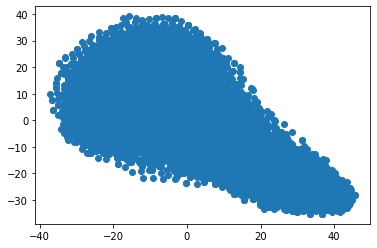

In [80]:
import matplotlib.pyplot as plt

plt.scatter(x_pre[:, 0], x_pre[:, 1])

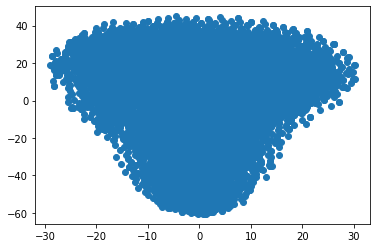

In [81]:
x = np.arange(num_user)

vectors = user2vec_3(x)

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
x_pre = tsne.fit_transform(vectors)

import matplotlib.pyplot as plt

plt.scatter(x_pre[:, 0], x_pre[:, 1])

In [84]:
from tensorflow.keras.models import load_model

recommender = load_model(path1)
user2vec = load_model(path2)

In [92]:
recommendation_system.predict([np.array([[1]]), np.array([[8]])])

array([[0.8173693]], dtype=float32)

In [ ]:
AUC